In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from Models import probitModel, logisticModel
from util import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from imblearn.over_sampling import SMOTE
import json
import joblib

In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [3]:
x = df.drop('mortality',axis=1)
y = df.mortality.values



In [4]:
base_pipeline = [
    ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
]

with open('probit.json','r') as f:
    probit_param = json.load(f)
with open('logistic.json','r') as f:
    logistic_param = json.load(f)

print(probit_param)
print(logistic_param)
    

{'l1': 0.0035582703469878574, 'l2': 0.00843913681699937, 'n_neighbors': 8.576290498043818}
{'l1': 0.2168472356533766, 'l2': 0.5551926359441683, 'n_neighbors': 3.0167325987967226}


# Probit Model

In [5]:
probit_pipeline = base_pipeline + [
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(probit_param['n_neighbors']))),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(probit_param['n_neighbors']))),
]
probit_pipeline = Pipeline(probit_pipeline)
probit_x = probit_pipeline.fit_transform(x)
probit = probitModel(l1=probit_param['l1'], l2=probit_param['l2'], w=0.75)

res_dict = probit.fit(probit_x, y, verbose=True, wald=True)
result = res_dict['result']
loss_values = res_dict['loss']

Current loss: 0.5324237807860028
Current loss: 0.49113600637744204
Current loss: 0.48828033164163215
Current loss: 0.48733837880388187
Current loss: 0.4865762367613734
Current loss: 0.48610596132915324
Current loss: 0.4859080117874277
Current loss: 0.48582580622910554
Current loss: 0.48577443123702396
Current loss: 0.4857551477774008
Current loss: 0.4857229338924131
Current loss: 0.485748425467695
Current loss: 0.485720674717366
Current loss: 0.4857453213511793
Current loss: 0.4857584052656313
Current loss: 0.4857052648221885
Current loss: 0.4857083669009429
Current loss: 0.48583554125280454
Current loss: 0.48568340238972324
Current loss: 0.4857143024695968
Current loss: 0.4857496752160193
Current loss: 0.4856921575480756
Current loss: 0.4856889399877224
Current loss: 0.48571996821484803
Current loss: 0.4856715914275097
Current loss: 0.4856678636688771
Current loss: 0.4856709303688485
Current loss: 0.48565461520730635
Current loss: 0.48568848622595817
Current loss: 0.4859413323424127
C

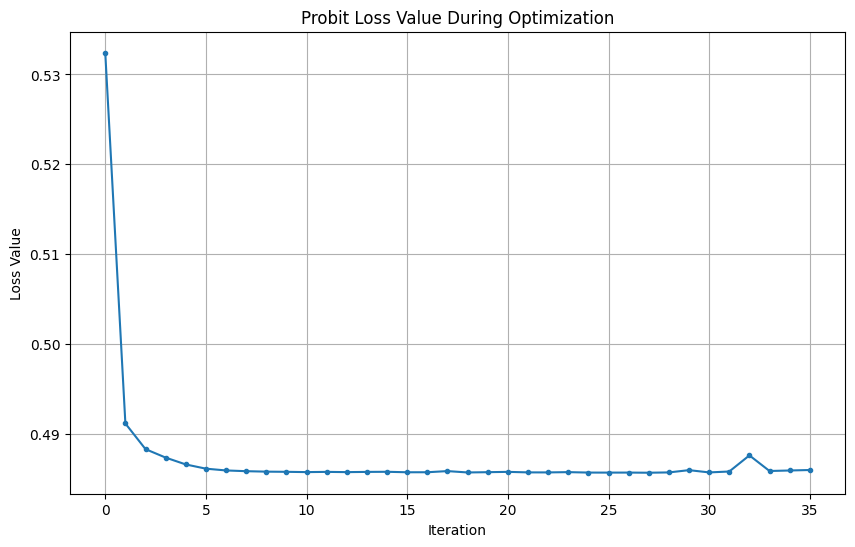

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Probit Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

## Wald test result and model interpretation

In [7]:
# iso_forest in pipeline will add a feature 'is_outlier', and last parameter in the model is the bias term
fnames = x.columns.to_list()+['is_outlier']+['bias']
# map the indices back to feature names
index_to_feature = dict(zip(range(len(fnames)),fnames))
wald_res = res_dict['wald_result']
wald_res['index'] = wald_res['index'].replace(index_to_feature, inplace=False)
wald_res.rename(columns={'index':'feature'}, inplace=True)
# filter out the significant features with 5% significance level
wald_res.query('`P>|z|` < 0.05')


,feature,coef,std err,z,P>|z|
0,Respiratory rate_mean,0.183323,0.0249,7.3649,0.0000
1,Heart Rate_max,0.121760,0.0310,3.9220,0.0001
2,Oxygen saturation_min,-0.056568,0.0155,-3.6480,0.0003
3,Respiratory rate_min,-0.028279,0.0088,-3.2111,0.0013
4,Oxygen saturation_mean,0.072097,0.0257,2.8057,0.0050
5,pH_min,-0.045216,0.0166,-2.7269,0.0064
6,Temperature_min,-0.077986,0.0290,-2.6927,0.0071
7,is_outlier,-0.116571,0.0517,-2.2527,0.0243
8,Temperature_mean,-0.101727,0.0464,-2.1939,0.0282


### Interpretation
Positive coef -> higher feature value, higher mortality risk

Negative coef -> higher feature value, lower mortality risk
- Higher Respiratory rate_mean increases mortality risk
- Higher Heart Rate_max increases mortality risk
- Higher Oxygen saturation_min decrease mortality risk (or lower increase risk)
- Higher Temperature_min decrease mortality risk (or lower increase risk)
- Higher pH_min decrease mortality risk (or lower increase risk)
- Higher Respiratory rate_min decrease mortality risk (or lower increase risk)

## Saving the model

In [8]:
joblib.dump(probit_pipeline, 'probit_pipeline.pkl')
joblib.dump(probit, 'probit.pkl')

['probit.pkl']

# Logistic Model

In [20]:
logistic_pipeline = base_pipeline + [ #
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(logistic_param['n_neighbors']))),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(logistic_param['n_neighbors']))),
]
logistic_pipeline = Pipeline(logistic_pipeline)
logistic_x = logistic_pipeline.fit_transform(x)
logistic = logisticModel(l1=logistic_param['l1'], l2=logistic_param['l2'], w=0.75)

res_dict = logistic.fit(logistic_x, y, verbose=True, wald=True)
result = res_dict['result']
loss_values = res_dict['loss']


Current loss: 10.90482363522619
Current loss: 0.7807312300167703
Current loss: 0.5204496704869361
Current loss: 6.302197849473595
Current loss: 2.0302846890203003
Current loss: 1.8481754259573437
Current loss: 2.7214527150538896
Current loss: 1.5488970942726628
Current loss: 1.7667932392780157
Current loss: 4.647231238684295
Current loss: 3.7592279570349536
Current loss: 2.2349014755266805
Current loss: 2.7582673999252942
Current loss: 4.803456262017207
Current loss: 1.9789984148381676
Current loss: 2.6168453372124465
Current loss: 2.884309959178962
Optimization result: Optimization terminated successfully
Wald test summary:
+----+---------+--------------+-----------+---------+---------+
|    |   index |         coef |   std err |       z |   P>|z| |
|----+---------+--------------+-----------+---------+---------|
|  0 |      31 | -5.42193e-05 |    0.0255 | -0.0021 |  0.9983 |
|  1 |      19 | -4.91003e-05 |    0.0242 | -0.002  |  0.9984 |
|  2 |      16 | -5.0607e-05  |    0.0445 | -0.

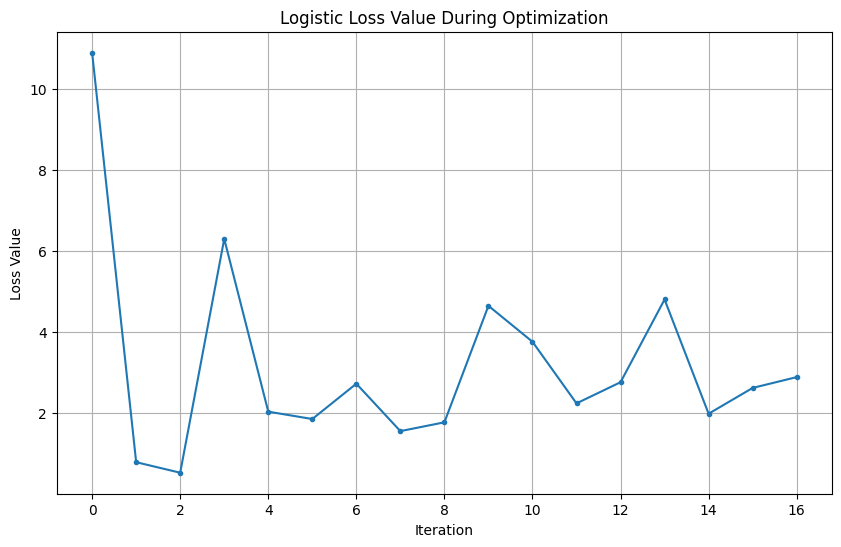

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Logistic Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

## Wald test result and model interpretation

In [22]:
# iso_forest in pipeline will add a feature 'is_outlier', and last parameter in the model is the bias term
fnames = x.columns.to_list()+['is_outlier']+['bias']
# map the indices back to feature names
index_to_feature = dict(zip(range(len(fnames)),fnames))
wald_res = res_dict['wald_result']
wald_res['index'] = wald_res['index'].replace(index_to_feature, inplace=False)
wald_res.rename(columns={'index':'feature'}, inplace=True)
# filter out the significant features with 5% significance level
wald_res.query('`P>|z|` < 0.05')


,feature,coef,std err,z,P>|z|


### Interpretation
Positive coef -> higher feature value, higher mortality risk

Negative coef -> higher feature value, lower mortality risk
- Higher Respiratory rate_mean increases mortality risk
- Higher Heart Rate_max increases mortality risk
- Higher Oxygen saturation_min decrease mortality risk (or lower increase risk)
- Higher Temperature_min decrease mortality risk (or lower increase risk)
- Higher pH_min decrease mortality risk (or lower increase risk)
- Higher Respiratory rate_min decrease mortality risk (or lower increase risk)

(Consistent with the probit model result)

## Saving the model

In [12]:
joblib.dump(logistic_pipeline, 'logistic_pipeline.pkl')
joblib.dump(logistic, 'logistic.pkl')

['logistic.pkl']